In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import torch
import torch.nn as nn

from sklearn.datasets import make_blobs

seaborn.set_style("darkgrid")


class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None, alpha=1.0, hybrid:bool=False):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
            hybrid: if True use label information only for negatives and
                use the related feature vector as positive
                (only works if labels are given)
        Returns:
            A loss scalar.
        """
        # device = (torch.device('cuda')
        #           if features.is_cuda
        #           else torch.device('cpu'))
        device = features.get_device()

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))
        
        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        if hybrid and labels is not None:
            # negative_mask for all features vectors with different labels
            negative_mask = (torch.ones_like(mask)-mask) * logits_mask
            # mask for the related feature vectors (use as positives)
            mask = torch.eye(batch_size, dtype=torch.float32).to(device).repeat(anchor_count, contrast_count) * logits_mask
            # logits_mask for used positives and negatives combined
            logits_mask = logits_mask + negative_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        if alpha == 1.0:
            mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        else:
            mask_alpha = torch.ones((batch_size,batch_size), dtype=torch.float32).fill_diagonal_(alpha).to(device).repeat(anchor_count, contrast_count).fill_diagonal_(1.0)
            mean_log_prob_pos = (mask * mask_alpha * log_prob).sum(1) / (mask * mask_alpha).sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [12]:
# alpha=5 opt eps is around 0.6099
# alpha=10 opt eps is around 0.7362
# alpha=2 opt eps is around 0.3832
eps = 0.6099

alpha = 5

cuda_device = 0
criterion = SupConLoss(temperature=0.1, contrast_mode="one")

with torch.no_grad():
    features = torch.Tensor([[[0,1],[0,1]],
                            [[0,1],[0,1]],
                            [[1,0],[1,0]],
                            [[1,0],[1,0]]])
    labels = torch.Tensor([1,1,2,2])
    features = torch.nn.functional.normalize(features, dim=2)

    criterion = criterion.cuda(device=cuda_device)
    features = features.cuda(device=cuda_device, non_blocking=True)
    labels = labels.cuda(device=cuda_device, non_blocking=True)
    loss_0 = criterion(features, labels, alpha=1, hybrid=False)
    loss_alpha_0 = criterion(features, labels, alpha=alpha, hybrid=False)
    print(f"[SupCon] loss: {loss_0} loss_alpha {loss_alpha_0}")


    features = torch.Tensor([[[0,1],[0,1]],
                            [[eps,1],[eps,1]],
                            [[1,0],[1,0]],
                            [[1,0],[1,0]]])
    labels = torch.Tensor([1,1,2,2])
    features = torch.nn.functional.normalize(features, dim=2)

    criterion = criterion.cuda(device=cuda_device)
    features = features.cuda(device=cuda_device, non_blocking=True)
    labels = labels.cuda(device=cuda_device, non_blocking=True)
    loss_1 = criterion(features, labels, alpha=1, hybrid=False)
    loss_alpha_1 = criterion(features, labels, alpha=alpha, hybrid=False)
    print(f"[SupCon] loss: {loss_1} loss_alpha {loss_alpha_1}")


    features = torch.Tensor([[[0,1],[eps,1]],
                            [[eps,1],[0,1]],
                            [[1,0],[1,0]],
                            [[1,0],[1,0]]])
    labels = torch.Tensor([1,1,2,2])
    features = torch.nn.functional.normalize(features, dim=2)

    criterion = criterion.cuda(device=cuda_device)
    features = features.cuda(device=cuda_device, non_blocking=True)
    labels = labels.cuda(device=cuda_device, non_blocking=True)
    loss_2 = criterion(features, labels, alpha=1, hybrid=False)
    loss_alpha_2 = criterion(features, labels, alpha=alpha, hybrid=False)
    print(f"[SupCon] loss: {loss_2} loss_alpha {loss_alpha_2}")
    print(f"{loss_1/loss_2} | {loss_alpha_1/loss_alpha_2}")

[SupCon] loss: 1.5695327520370483 loss_alpha 1.5695327520370483
[SupCon] loss: 1.7651050090789795 loss_alpha 1.3671231269836426
[SupCon] loss: 1.7651050090789795 loss_alpha 1.964096188545227
1.0 | 0.696057140827179


In [115]:
alpha = 5
n_samples = 26
n_features = 2

cuda_device = 0
criterion = SupConLoss(temperature=0.1, contrast_mode="all")

with torch.no_grad():
    features_a, labels = make_blobs(n_samples=n_samples, centers=[[0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], n_features=n_features, shuffle=False)
    features_b, _ = make_blobs(n_samples=n_samples, centers=[[0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], n_features=n_features, shuffle=False)
    features_a = torch.tensor(features_a)
    features_b = torch.tensor(features_b)
    features = torch.stack((features_a, features_b), dim=1)
    labels = torch.tensor(labels)
    features = torch.nn.functional.normalize(features, dim=2)

    criterion = criterion.cuda(device=cuda_device)
    features = features.cuda(device=cuda_device, non_blocking=True)
    labels = labels.cuda(device=cuda_device, non_blocking=True)
    loss_0 = criterion(features, labels, alpha=1, hybrid=False)
    loss_alpha_0 = criterion(features, labels, alpha=alpha, hybrid=False)
    print(f"[SupCon] loss: {loss_0} loss_alpha {loss_alpha_0}")


    features_1, labels = make_blobs(n_samples=n_samples, centers=[[10,0], [0,10], [-10,0], [0,-10], [10,10], [-10,-10]], n_features=n_features, shuffle=False)
    features_2, _ = make_blobs(n_samples=n_samples, centers=[[10,0], [0,10], [-10,0], [0,-10], [10,10], [-10,-10]], n_features=n_features, shuffle=False)
    features_1 = torch.tensor(features_1)
    features_2 = torch.tensor(features_2)
    features = torch.stack((features_1, features_2), dim=1)
    labels = torch.tensor(labels)
    features = torch.nn.functional.normalize(features, dim=2)

    criterion = criterion.cuda(device=cuda_device)
    features = features.cuda(device=cuda_device, non_blocking=True)
    labels = labels.cuda(device=cuda_device, non_blocking=True)
    loss_1 = criterion(features, labels, alpha=1, hybrid=False)
    loss_alpha_1 = criterion(features, labels, alpha=alpha, hybrid=False)
    print(f"[SupCon] loss: {loss_1} loss_alpha {loss_alpha_1}")


    eps, _ = make_blobs(n_samples=n_samples, centers=[[0,0]], n_features=n_features, cluster_std=0.01)
    features = torch.stack((features_1, features_1), dim=1)
    features = torch.nn.functional.normalize(features, dim=2)

    criterion = criterion.cuda(device=cuda_device)
    features = features.cuda(device=cuda_device, non_blocking=True)
    labels = labels.cuda(device=cuda_device, non_blocking=True)
    loss_2 = criterion(features, labels, alpha=1, hybrid=False)
    loss_alpha_2 = criterion(features, labels, alpha=alpha, hybrid=False)
    print(f"[SupCon] loss: {loss_2} loss_alpha {loss_alpha_2}")
    print(f"{loss_1/loss_2} | {loss_alpha_1/loss_alpha_2}")

[SupCon] loss: 17.73935657787991 loss_alpha 17.517706525722513
[SupCon] loss: 3.072376222170127 loss_alpha 3.060771979829216
[SupCon] loss: 3.08772761205107 loss_alpha 3.053628279922736
0.9950282564365367 | 1.0023394137241421


In [116]:
alpha = 5
n_samples = 4

cuda_device = 0
criterion = SupConLoss(temperature=0.1, contrast_mode="one")

features, labels = make_blobs(n_samples=n_samples, centers=[[0,0], [0,0]], n_features=2, shuffle=False)
features_2, _ = make_blobs(n_samples=n_samples, centers=[[0,0], [0,0]], n_features=2, shuffle=False)
features = torch.tensor(features)
features_2 = torch.tensor(features_2)
features = torch.stack((features, features_2), dim=1)
labels = torch.tensor(labels)
features = torch.nn.functional.normalize(features, dim=2)

criterion = criterion.cuda(device=cuda_device)
features = features.cuda(device=cuda_device, non_blocking=True)
labels = labels.cuda(device=cuda_device, non_blocking=True)
loss_0 = criterion(features, labels, alpha=1, hybrid=False)
loss_alpha_0 = criterion(features, labels, alpha=alpha, hybrid=False)
print(f"[SupCon] loss: {loss_0} loss_alpha {loss_alpha_0}")


features_1, labels = make_blobs(n_samples=n_samples, centers=[[5,0], [0,5]], n_features=2, shuffle=False)
features_2, _ = make_blobs(n_samples=n_samples, centers=[[5,0], [0,5]], n_features=2, shuffle=False)
features_1 = torch.tensor(features_1)
features_2 = torch.tensor(features_2)
features = torch.stack((features_1, features_2), dim=1)
labels = torch.tensor(labels)
features = torch.nn.functional.normalize(features, dim=2)

criterion = criterion.cuda(device=cuda_device)
features = features.cuda(device=cuda_device, non_blocking=True)
labels = labels.cuda(device=cuda_device, non_blocking=True)
loss_1 = criterion(features, labels, alpha=1, hybrid=False)
loss_alpha_1 = criterion(features, labels, alpha=alpha, hybrid=False)
print(f"[SupCon] loss: {loss_1} loss_alpha {loss_alpha_1}")


eps, _ = make_blobs(n_samples=n_samples, centers=[[0,0]], n_features=2, cluster_std=0.01)
features = torch.stack((features_1, features_1), dim=1)
features = torch.nn.functional.normalize(features, dim=2)

criterion = criterion.cuda(device=cuda_device)
features = features.cuda(device=cuda_device, non_blocking=True)
labels = labels.cuda(device=cuda_device, non_blocking=True)
loss_2 = criterion(features, labels, alpha=1, hybrid=False)
loss_alpha_2 = criterion(features, labels, alpha=alpha, hybrid=False)
print(f"[SupCon] loss: {loss_2} loss_alpha {loss_alpha_2}")
print(f"{loss_1/loss_2} | {loss_alpha_1/loss_alpha_2}")

[SupCon] loss: 13.572842244660283 loss_alpha 9.941379155877454
[SupCon] loss: 1.6214563776932778 loss_alpha 1.5295816032859362
[SupCon] loss: 1.5878630935673126 loss_alpha 1.460457282149856
1.0211562849858133 | 1.047330601162347


--------------------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import torch

from losses import SupConLoss

seaborn.set_style("darkgrid")

<Axes: xlabel='x', ylabel='y'>

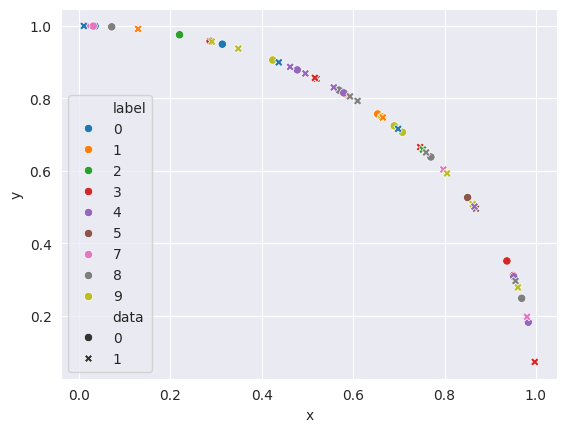

In [87]:
cuda_device = 0

criterion = SupConLoss(temperature=0.1)

# # [SupCon] loss: 1.5703439712524414
# # [SupConHybrid] loss: 0.00032951406319625676
# features = torch.Tensor([[[0,1],[0.05,1.05]],
#                          [[-0.1,0.9],[-0.05,0.85]],
#                          [[1,0],[0.95,-0.05]],
#                          [[1.05,0.1],[1.1,0.05]]])
# labels = torch.Tensor([1,1,2,2])

# # [SupCon] loss: 1.5700136423110962
# # [SupConHybrid] loss: 0.00030913689988665283
# features = torch.Tensor([[[0,1],[0,1]],
#                          [[-0.1,0.9],[-0.1,0.9]],
#                          [[1,0],[1,0]],
#                          [[1.05,0.1],[1.05,0.1]]])
# labels = torch.Tensor([1,1,2,2])

# # [SupCon] loss: 1.5695327520370483
# # [SupConHybrid] loss: 0.000259512074990198
# features = torch.Tensor([[[0,1],[0,1]],
#                          [[0,1],[0,1]],
#                          [[1,0],[1,0]],
#                          [[1,0],[1,0]]])
# labels = torch.Tensor([1,1,2,2])

# # [SupCon] loss: 0.0001297619310207665
# # [SupConHybrid] loss: 0.0001297619310207665
# features = torch.Tensor([[[0,1],[0,1]],
#                          [[1,0],[1,0]]])
# labels = torch.Tensor([1,2])


# [SupCon] loss: 3.2001540660858154
# [SupConHybrid] loss: 0.006874409504234791
features = torch.Tensor([[[0,1],[0.01,0.99]],
                         [[-0.2,1.2],[-0.21,1.19]],
                         [[0.2,0.9],[0.19,0.89]],
                         [[0.2,1.3],[0.21,1.31]],
                         [[-0.25,0.85],[-0.24,0.86]],
                         [[1,0],[1.01,0.01]],
                         [[1.15,0.2],[1.16,0.19]],
                         [[0.85,0.2],[0.84,0.21]],
                         [[1,0.1],[1.01,0.09]],
                         [[0.9,-0.15],[0.91,-0.16]]])
labels = torch.Tensor([1,1,1,1,1,2,2,2,2,2])


# [SupCon] loss: 10.1373291015625
# [SupConHybrid] loss: 2.2230217456817627
features = torch.Tensor([[[0,1],[0.01,0.99]],
                         [[-0.2,1.2],[-0.21,1.19]],
                         [[0.2,0.9],[0.19,0.89]],
                         [[0.2,1.3],[0.21,1.31]],
                         [[-0.25,0.85],[-0.24,0.86]],
                         [[1,0],[1.01,0.01]],
                         [[1.15,0.2],[1.16,0.19]],
                         [[0.85,0.2],[0.84,0.21]],
                         [[1,0.1],[1.01,0.09]],
                         [[0.9,-0.15],[0.91,-0.16]]])
labels = torch.Tensor([1,2,1,2,1,2,1,2,1,2])

# [SupCon] loss: 10.133689880371094
# [SupConHybrid] loss: 2.220616102218628
features = torch.Tensor([[[0,1],[0,1]],
                         [[-0.2,1.2],[-0.2,1.2]],
                         [[0.2,0.9],[0.2,0.9]],
                         [[0.2,1.3],[0.2,1.3]],
                         [[-0.25,0.85],[-0.25,0.85]],
                         [[1,0],[1,0]],
                         [[1.15,0.2],[1.15,0.2]],
                         [[0.85,0.2],[0.85,0.2]],
                         [[1,0.1],[1,0.1]],
                         [[0.9,-0.15],[0.9,-0.15]]])
labels = torch.Tensor([1,2,1,2,1,2,1,2,1,2])



tensor_rand = torch.rand((26,2))
tensor_rand_2 = torch.rand((26,2))
features = torch.stack((tensor_rand, tensor_rand_2), dim=1)
labels = torch.randint(0, 10, (26,))

features = torch.nn.functional.normalize(features, dim=2)
df = pd.DataFrame.from_dict({'x': torch.cat((features[:,0], features[:,1]))[:,0], 'y': torch.cat((features[:,0], features[:,1]))[:,1],
                             'label': torch.cat((labels,labels)), 'data': len(labels)*[0]+len(labels)*[1]})
seaborn.scatterplot(df, x='x', y='y', hue='label', style='data', palette='tab10')

In [86]:
cuda_device = 0
criterion = criterion.cuda(device=cuda_device)
features = features.cuda(device=cuda_device, non_blocking=True)
labels = labels.cuda(device=cuda_device, non_blocking=True)

loss = criterion(features, labels, hybrid=False)
print(f"[SupCon] loss: {loss}")

loss = criterion(features, labels, hybrid=True)
print(f"[SupConHybrid] loss: {loss}")

[SupCon] loss: 6.800449848175049
[SupConHybrid] loss: 6.388702392578125
